In [1]:
%matplotlib inline

We will be covering

* [Marking bad channels](#Marking-bad-channels)
* [Marking bad epochs](#Marking-bad-epochs)
* [Using autoreject to automatically mark bad channels and epochs](#Autoreject)

Let's first load the raw data as usual

In [2]:
 import numpy as np
import mne
from mne.datasets import sample

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)  # already has an EEG ref

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


Marking bad channels
==================

If you already know which are the bad channels, simply do:

In [3]:
raw.info['bads'] = ['MEG 2443']

You can also mark them interactively in `raw.plot()`. The bad channel is shown in gray

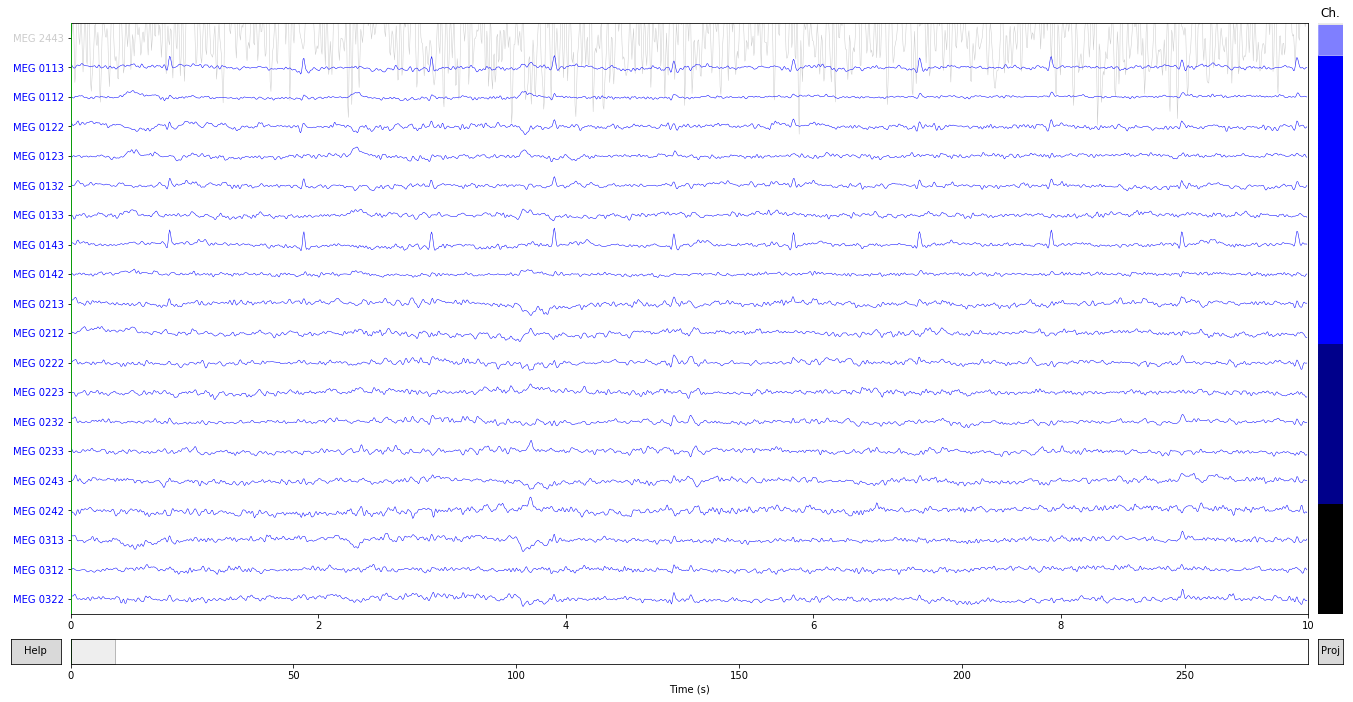

In [4]:
ch_names = raw.info['ch_names'].copy()
ch_names.remove('MEG 2443')
raw.reorder_channels(['MEG 2443'] + ch_names)
raw.plot();

It's not only `raw`. You can mark bads also in `evoked`. Let's first read in the evoked data.

Reading /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


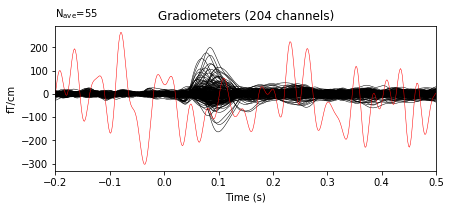

In [5]:
# Reading data with a bad channel marked as bad:
fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked = mne.read_evokeds(fname, condition='Left Auditory',
                          baseline=(None, 0))
evoked.pick_types(meg='grad', eeg=False, exclude=[])

# plot with bads
evoked.plot(exclude=[], time_unit='s');

It's also possible to repair the bad channels using interpolation

In [6]:
evoked.interpolate_bads(reset_bads=False, verbose=False);

Let’s plot the cleaned data

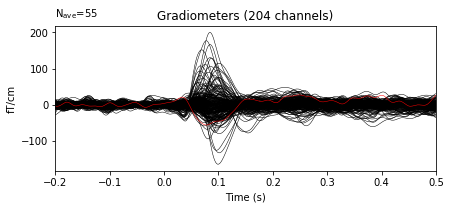

In [7]:
evoked.plot(exclude=[], time_unit='s');

Marking bad epochs
--------------------

MNE allows you to specify rejection dictionary based on peak-to-peak thresholds for each channel type

In [8]:
reject = dict(grad=4000e-13, mag=4e-12, eog=200e-6)

In [9]:
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {"auditory/left": 1}
tmin, tmax = -0.2, 0.5
baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True,
                       stim=False, exclude='bads')
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject,                    
                    preload=True)

319 events found
Event IDs: [ 1  2  3  4  5 32]
72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
9 bad epochs dropped


You can also reject after constructing epochs, just do:

In [10]:
reject.update({'eog': 150e-6})
epochs.drop_bad(reject=reject)

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
8 bad epochs dropped


<Epochs  |   55 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~19.9 MB, data loaded,
 'auditory/left': 55>

But the thresholds need to be stricter each time.

Tuning rejection thresholds
---------------------------

In [11]:
import matplotlib.pyplot as plt
from ipywidgets import interact

picks = mne.pick_types(raw.info, meg=False, eeg=True)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                    
                    preload=True)

def reject_epochs(reject):
    reject = dict(eeg=reject * 1e-6)
    evoked = epochs.copy().drop_bad(reject=reject, verbose=False).average()
    evoked.plot(spatial_colors=True)
    print('Number of epochs retained: %d/%d' % (evoked.nave, len(epochs)))

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Loading data for 72 events and 106 original time points ...
0 bad epochs dropped


In [12]:
interact(reject_epochs, reject=(35, 250, 10));

interactive(children=(IntSlider(value=135, description='reject', max=250, min=35, step=10), Output()), _dom_cl…

Autoreject
----------

Autoreject (global) can compute the rejection dictionary automatically

In [13]:
from autoreject import get_rejection_threshold  # noqa
reject = get_rejection_threshold(epochs)
print(reject)

Estimating rejection dictionary for eeg
{'eeg': 8.687666582562178e-05}


Autoreject (local) finds per channel thresholds

In [14]:
import numpy as np
from autoreject import AutoReject

n_interpolates = np.array([1, 2, 4])
consensus = np.linspace(0.5, 1.0, 6)

ar = AutoReject(n_interpolates, consensus, thresh_method='random_search',
                random_state=42)

Now, we find the rejection thresholds per-channel and optimize for the number of channels to be interpolated.

In [15]:
# Note that fitting and transforming can be done on different compatible
# portions of data if needed.
raw.info['bads'] = []
picks = mne.pick_types(raw.info, meg='grad', eeg=False)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                    
                    preload=True)
ar.fit(epochs['auditory/left'])

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
4 projection items activated
Loading data for 72 events and 106 original time points ...
0 bad epochs dropped
84 coil definitions read
Running autoreject on ch_type=grad
[........................................] 100.00% Creating augmented epochs | Computing thresholds ...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0

AutoReject(consensus=array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), cv=10,
      n_interpolate=array([1, 2, 4]), n_jobs=1, picks=None,
      random_state=42, thresh_method='random_search',
      verbose='progressbar')

Now, we can look at the rejection thresholds for each channel

In [16]:
for ch_name in epochs.info['ch_names'][:5]:
     print('%s: %s' % (ch_name, ar.threshes_[ch_name]))

MEG 2443: 5.0754296687618994e-11
MEG 0113: 4.7046358028474774e-11
MEG 0112: 2.078659797976023e-11
MEG 0122: 5.5037904494357155e-11
MEG 0123: 2.3449336826907813e-11


We can check what applying autoreject would do to the epochs:
    
* Good data (light red)
* Bad segment but not to be interpolated (medium dark red)
* Bad segment to be interpolated (dark red)

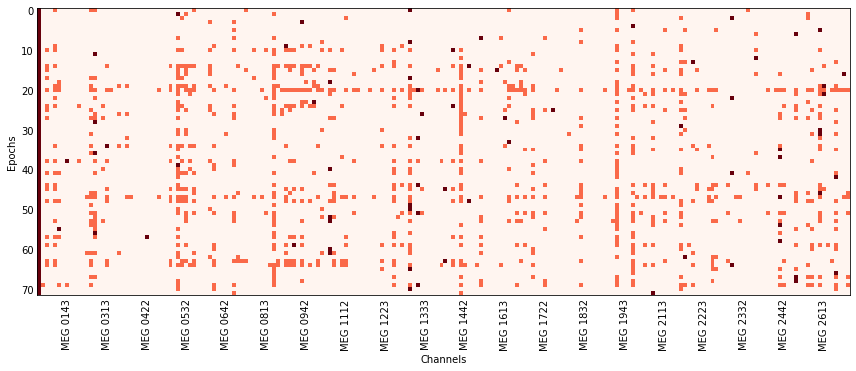

In [17]:
reject_log = ar.get_reject_log(epochs['auditory/left'])
reject_log.plot()

Another way to visualize this is to plot them on the epochs

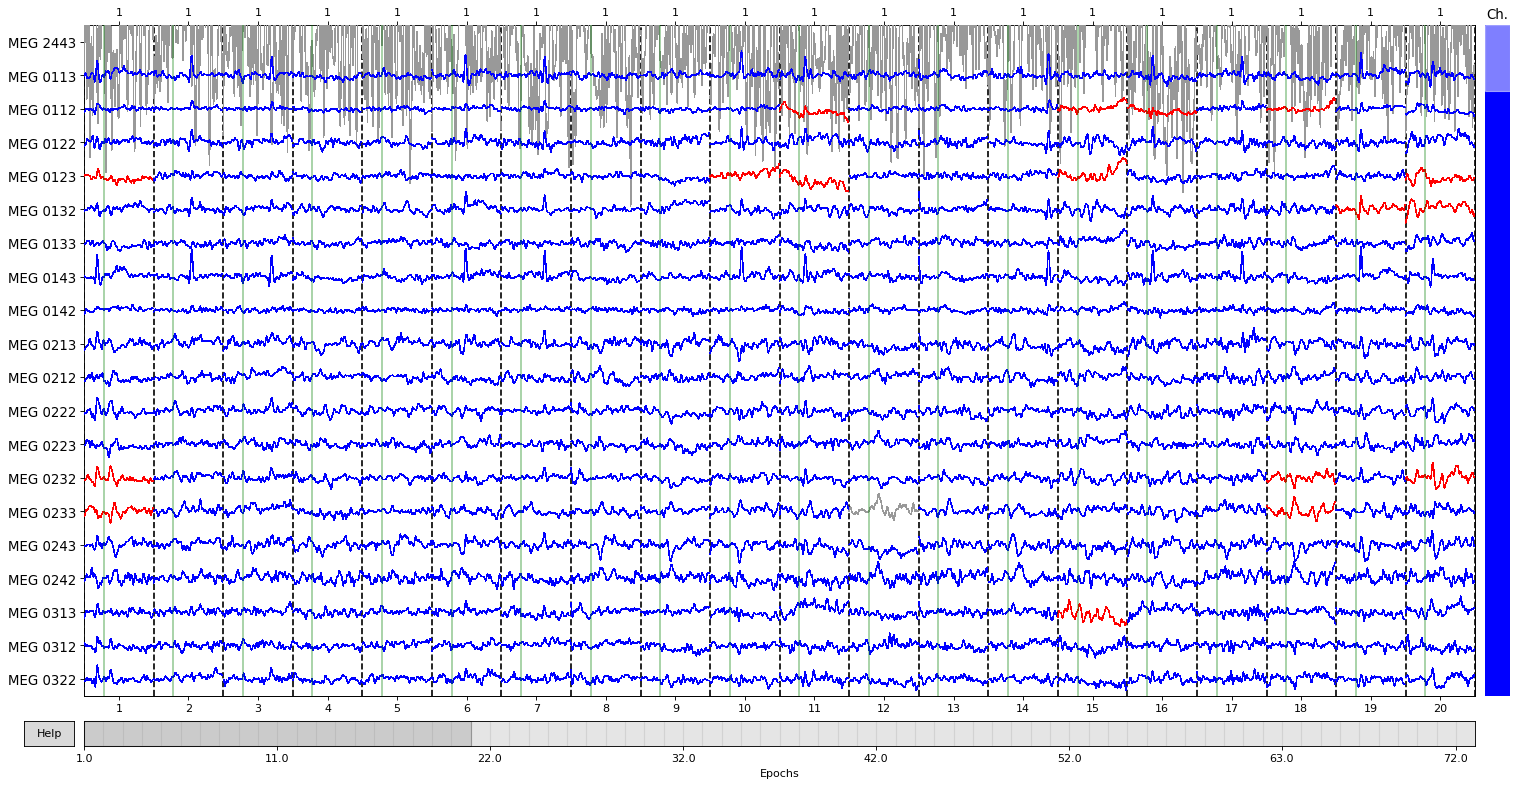

In [18]:
reject_log.plot_epochs(epochs['auditory/left']);

We can apply these rejection thresholds to new (or to the old) data:

In [19]:
epochs_clean = ar.transform(epochs['auditory/left'])

[........................................] 100.00% Repairing epochs |   

/home/mainak/Desktop/projects/github_repos/autoreject/autoreject/autoreject.py:1130: UserWarning: No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
  "No bad epochs were found for your data. Returning "


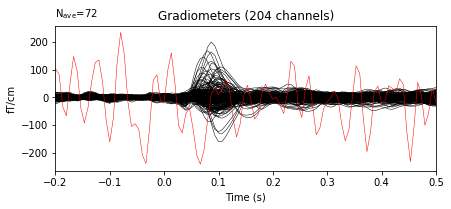

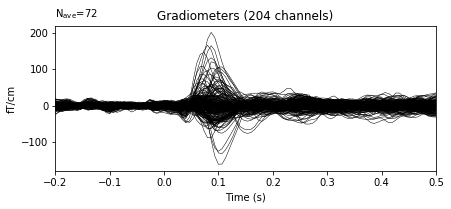

In [20]:
evoked = epochs['auditory/left'].average()
evoked.info['bads'] = ['MEG 2443']
evoked.plot(exclude=[])

evoked_clean = epochs_clean.average()
evoked_clean.plot(exclude=[])
evoked_clean.info['bads'] = ['MEG 2443']

For more info, visit

[http://autoreject.github.io/](http://autoreject.github.io/)